## 이미지 분류를 위한 심층 신경망 : 애플리케이션

이 과정을 마치면 4 주차의 마지막 프로그래밍 과제와 이 과정의 마지막 프로그래밍 과제를 마친 것입니다!

이전 과제에서 구현한 기능을 사용하여 심층 네트워크를 구축하고, 이를 고양이 대 비-고양이 분류에 적용합니다. 바라건대, 이전 로지스틱 회귀 구현에 비해 정확도가 향상 될 것입니다.

이 과제 후 다음을 수행 할 수 있습니다:
* 지도 학습에 심층 신경망을 구축하고 적용합니다.

시작합시다!

### 1. 패키지

먼저 이 과제 중에 필요한 모든 패키지를 가져 오겠습니다.

* numpy는 Python을 사용한 과학 컴퓨팅의 기본 패키지입니다.
* matplotlib는 Python에서 그래프를 그리는 라이브러리입니다.
* h5py는 H5 파일에 저장된 데이터 세트와 상호 작용하는 공통 패키지입니다.
* 여기서 PIL과 scipy는 마지막에 자신의 사진으로 모델을 테스트하는 데 사용됩니다.
* dnn_app_utils는이 노트북에 대한 "심층 신경망 구축 : 단계별"과제에서 구현된 기능을 제공합니다.
* np.random.seed (1)는 모든 임의의 함수 호출을 일관되게 유지하는 데 사용됩니다. 귀하의 작업을 평가하는 데 도움이됩니다.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### 2. 데이터 세트
"신경망으로서의 로지스틱 회귀"(과제 2)에서와 동일한 "Cat vs non-Cat"데이터 세트를 사용합니다. 당신이 만든 모델은 고양이와 고양이가 아닌 이미지를 분류 할 때 70 %의 테스트 정확도를 가졌습니다. 바라건대 새 모델이 더 잘 작동하기를 바랍니다!

문제 설명 : 다음을 포함하는 데이터 세트 ( "data.h5")가 제공됩니다.

- cat (1) 또는 non-cat (0)으로 레이블이 지정된 m_train 이미지의 훈련 세트
- cat 및 non-cat으로 라벨이 지정된 m_test 이미지의 테스트 세트
- 각 이미지는 모양 (num_px, num_px, 3)이며 3은 3 채널 (RGB) 용입니다.

데이터 세트에 대해 좀 더 알아 봅시다. 아래 셀을 실행하여 데이터를 로드하십시오.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

다음 코드는 데이터 세트의 이미지를 보여줍니다. 인덱스를 변경하고 셀을 여러 번 다시 실행하여 다른 이미지를 볼 수 있습니다.

y = 0. It's a non-cat picture.


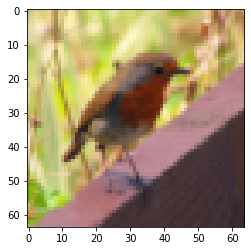

In [3]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


평소와 같이 이미지를 네트워크에 공급하기 전에 이미지의 모양을 변경하고 정규화합니다. 코드는 아래 셀에 있습니다.

<img src="./images/imvectorkiank.png">

In [5]:

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$는 $64 \times 64 \times 3 $와 같으며 하나의 재구성 된 이미지 벡터의 크기입니다.

### 3. 모델 아키텍처
이제 데이터 세트에 익숙해 졌으므로 고양이 이미지와 고양이 이미지가 아닌 이미지를 구별하기 위해 심층 신경망을 구축 할 차례입니다.

두 가지 다른 모델을 빌드합니다.

* 2-층 신경망
* L-층 심층 신경망
* 그런 다음 이러한 모델의 성능을 비교하고 $ L $에 대해 다른 값을 시도합니다.

두 가지 아키텍처를 살펴 보겠습니다.

#### 3.1. 2-층 신경망

<img src="./images/2layerNN_kiank.png">

:

* 입력은 $ (12288,1) $ 크기의 벡터로 평면화 된 (64,64,3) 이미지입니다.
* 해당 벡터 : $ [x_0, x_1, ..., x_ {12287}]^T $에  $(n^{[1]}, 12288)$. 크기의 가중치 행렬 $ W^{[1]} $를 곱합니다.
* 그런 다음 bias 항을 추가하고 relu를 사용하여 $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$. 벡터를 얻습니다.
* 그런 다음 동일한 과정을 반복합니다.
* 결과 벡터에 $ W^{[2]} $를 곱하고 바이어스를 더합니다.
* 마지막으로 결과의 시그 모이 드를 취합니다. 0.5보다 크면 고양이로 분류합니다.


#### 3.2. L- 심층 신경망
위의 표현으로 L-층 심층 신경망을 표현하는 것은 어렵습니다. 그러나 다음은 단순화 된 네트워크 표현입니다.

<img src="./images/LlayerNN_kiank.png">

:

* 입력은 (12288,1) 크기의 벡터로 병합 된 (64,64,3) 이미지입니다.
* 해당 벡터 :  $[x_0,x_1,...,x_{12287}]^T$에 가중치 행렬 $ W^{[1]} $를 곱한 다음 bias $ b^{[1 ]} $. 그 결과를 선형 단위라고 합니다.
* 다음으로, 당신은 선형 단위의 relu를 취합니다. 이 프로세스는 모델 아키텍처에 따라  $(W^{[l]}, b^{[l]})$ 마다 여러 번 반복 될 수 있습니다.
* 마지막으로 최종 선형단위의 결과에 시그모이드를 취합니다. 0.5보다 크면 고양이로 분류합니다.

#### 3.3. 일반적인 방법론
평소와 같이 모델을 구축하기 위해 딥 러닝 방법론을 따릅니다.
```
1. 매개변수 초기화 / 초매개변수 정의
2. num_iterations를 위한 루프 :
     a. 순전파
     b. 비용 함수 계산
     c. 역전파
     d. 매개변수 업데이트 (매개변수 및 backprop의 그래디언트 사용)
4. 훈련된 매개변수를 사용하여 레이블 예측
```
이제 이 두 모델을 구현해 보겠습니다!

### 4-2 계층 신경망

**(1) 연습 문제** : 이전 과제에서 구현한 도우미 함수를 사용하여 LINEAR -> RELU -> LINEAR -> SIGMOID 구조로 2-층 신경망을 구축합니다. 필요한 함수와 입력은 다음과 같습니다.
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = 
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = 
        A2, cache2 = 
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = 
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = 
        dA0, dW1, db1 = 
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = 
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

SyntaxError: invalid syntax (<ipython-input-7-d3e80ae0dac5>, line 27)

아래 셀을 실행하여 매개변수를 학습 시키십시오. 모델이 실행되는지 확인하십시오. 비용은 감소해야 합니다. 2500 회 반복을 실행하는 데 최대 5 분이 걸릴 수 있습니다. "반복 0 후 비용"이 아래의 예상 출력과 일치하는지 확인하고, 그렇지 않으면, 노트북 상단 막대의 사각형 (⬛)을 클릭하여 셀을 중지하고 오류를 찾습니다.

In [ ]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.048554785628770226 </td>
    </tr>
</table>


벡터화된 구현을 구축했습니다. 그렇지 않으면 이것을 훈련하는데 10 배 더 오래 걸렸을 수 있습니다.

이제 훈련된 매개변수를 사용하여 데이터 세트의 이미지를 분류 할 수 있습니다. 학습 및 테스트 세트에 대한 예측을 보려면 아래 셀을 실행하십시오.

In [ ]:
predictions_train = predict(train_x, train_y, parameters)

**Expected Output**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [ ]:
predictions_test = predict(test_x, test_y, parameters)

**Expected Output**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

참고 : 모델을 더 적은 반복 (예: 1500)으로 실행하면 테스트 세트에서 더 나은 정확도를 얻을 수 있습니다. 이를 "조기 중지(earlay stopping)"라고 하며 다음 과정에서 이에 대해 설명하겠습니다. 조기 중지는 과적합을 방지하는 방법입니다.

축하합니다! 2-층 신경망이 로지스틱 회귀 구현 (70 %, 2 주차 과제)보다 더 나은 성능 (72 %)을 갖는 것 같습니다. $L$-층 모델로 더 잘할 수 있는지 살펴 보겠습니다.

### 5. L-층 신경망
**(2) 연습문제** : 이전에 구현한 도우미 함수를 사용하여 [LINEAR -> RELU] $ \times $ (L-1) -> LINEAR -> SIGMOID 구조로 $ L$-층 신경망을 구축합니다. 필요한 함수와 입력은 다음과 같습니다.

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [ ]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = 
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches =
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = 
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads =
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = 
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

이제 모델을 4 계층 신경망으로 훈련합니다.

아래 셀을 실행하여 모델을 학습 시키십시오. 반복 할 때마다 비용이 감소해야합니다. 2500 회 반복을 실행하는 데 최대 5 분이 걸릴 수 있습니다. "반복 0 후 비용"이 아래의 예상 출력과 일치하는지 확인하고 노트북 상단 막대의 사각형 (⬛)을 클릭하지 않으면 셀을 중지하고 오류를 찾습니다.

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [ ]:
pred_train = predict(train_x, train_y, parameters)

In [ ]:
pred_test = predict(test_x, test_y, parameters)

**Expected Output**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

축하합니다! 동일한 테스트 세트에서 4-층 신경망의 성능 (80 %)이 2-층 신경망 (72 %)보다 나은 것 같습니다.

이 작업에 좋은 성능입니다. 

"심층 신경망 개선"에 대한 다음 과정에서는 더 나은 하이퍼 파라미터 (learning_rate, layers_dims, num_iterations 및 다음 과정에서도 배우게 될 기타)를 체계적으로 검색하여 더 높은 정확도를 얻는 방법을 배우게됩니다.

### 6) 결과 분석

먼저 L-층 모델이 잘못 레이블을 붙인 이미지를 살펴 보겠습니다. 라벨이 잘못 지정된 이미지가 몇 개 표시됩니다.

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

모델이 제대로 수행하지 못하는 몇 가지 이미지 유형은 다음과 같습니다.

* 특이한 위치의 고양이 몸
* 비슷한 색상의 배경에 고양이가 나타납니다.
* 특이한 고양이 색과 종
* 카메라 앵글
* 그림의 밝기
* 규모 변화 (고양이는 이미지에서 매우 크거나 작음)


### 7) 자신의 이미지로 테스트 (선택 사항 / 무게 연습)
이 과제를 마치신 것을 축하드립니다. 자신의 이미지를 사용하고 모델의 출력을 볼 수 있습니다. 하기 위해서:

1. 이 Jupyter Notebook의 디렉토리에 있는 "images"폴더에 이미지를 추가합니다.
2. 다음 코드에서 이미지 이름 변경
3. 코드를 실행하고 알고리즘이 올바른지 확인하십시오 (1 = 고양이, 0 = 고양이가 아님)!

In [ ]:
from skimage.transform import resize
from imageio import imread

## START CODE HERE ##
my_image =               # change this to the name of your image file 
my_label_y =             # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(imread(fname))
image = image/255.
print(image.shape, num_px)
my_image = resize(image,(num_px,num_px))
my_image = my_image.reshape((1, num_px*num_px*3)).T

my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

참조 :

외부 모듈 자동 다시로드 : http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython